# Cats vs Dogs Classification - CNN VS ResNet

## Imports and setup dataset

In [2]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the Cats vs Dogs dataset from TensorFlow datasets
dataset_name = "cats_vs_dogs"

# Download the dataset
(train_ds_og, val_ds_og), metadata = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:]"],
    with_info=True,
    as_supervised=True,
)

WIDTH, HEIGHT = 128, 128

BATCH = 32


from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocessing function to normalize images using VGG16's preprocess_input
def preprocess(image, label):
    image = tf.image.resize(image, (WIDTH, HEIGHT))  # Resize the image to 224x224 as required by VGG16
    image = preprocess_input(image)  # Apply VGG16 preprocessing (normalize to match the VGG16 training data)
    return image, label


AUTOTUNE = tf.data.AUTOTUNE

# No preprocessing function for the original dataset
def preprocess_original(image, label):
    image = tf.image.resize(image, (WIDTH, HEIGHT))  # Resize only, no normalization
    return image, label

# Creating an unprocessed validation dataset (original_val_ds)
original_val_ds = val_ds_og.map(preprocess_original).batch(BATCH)

# Apply preprocessing to the dataset used for training
train_ds = train_ds_og.map(preprocess).shuffle(1000).batch(BATCH)
val_ds = val_ds_og.map(preprocess).batch(BATCH)

# Prefetch and caching for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Convolutional Network

In [4]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , CSVLogger
from tensorflow.keras import Input
import tensorflow as tf



inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_cnn = tf.keras.Model(inputs=inputs, outputs=outputs)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Residual Network

In [6]:
from tensorflow.keras.layers import Add, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Residual Block with 1x1 Conv for shortcut
def residual_block(x, filters):
    shortcut = x  # Save input for the skip connection
    
    # Use 1x1 Conv to match dimensions if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)

    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same', activation=None)(x)  # No activation for the second conv layer
    x = BatchNormalization()(x)

    # Add the shortcut (skip connection)
    x = Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)  # Activation after the skip connection
    
    return x

# Building the CNN with simplified Residual Connections
inputs = Input(shape=(WIDTH, HEIGHT, 3))

# Convolutional block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Reduced dropout to match base model

# Residual Block 1 (reduced filters to 32)
x = residual_block(x, 32)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Residual Block 2 (reduced filters to 64)
x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Residual Block 3 (reduced filters to 128)
x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create and compile the model
model_resnet = Model(inputs=inputs, outputs=outputs)
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      1,056 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ max_pooling2d_9[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat

 Total params: 4,507,041 (17.19 MB)

 Trainable params: 4,505,057 (17.19 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Train Setup

In [7]:
models_path = "/Users/leonardo/Documents/Projects/classification-attention-layer/models"

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience= 4, 
                                            verbose= 1, 
                                            factor= 0.75, 
                                            min_lr= 0.00001)

filename='log.csv'
history_logger= CSVLogger(filename, separator=",", append=True)


callbacks = [
    learning_rate_reduction, 
    checkpoint_acc, 
    history_logger
]

## Train the models

In [8]:
import time

EPOCHS = 30
beg = int(time.time())

hist_cnn = model_cnn.fit(
        train_ds,
        epochs = EPOCHS,
        validation_data = val_ds,
        callbacks = callbacks
)

end = int(time.time())
t = end - beg
hrs = t // 3600
mins = (t - 3600 * hrs) // 60
secs = t % 60
print("training took {} hrs -- {} mins -- {} secs".format(hrs,mins,secs))

Epoch 1/30


2024-10-12 15:23:46.728290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


582/582 ━━━━━━━━━━━━━━━━━━━━ 50s 76ms/step - accuracy: 0.5913 - loss: 0.8535 - val_accuracy: 0.5170 - val_loss: 1.9670 - learning_rate: 0.0010
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.6865 - loss: 0.5966 - val_accuracy: 0.5451 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.7436 - loss: 0.5168 - val_accuracy: 0.5391 - val_loss: 1.8458 - learning_rate: 0.0010
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.7680 - loss: 0.4793 - val_accuracy: 0.5972 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.7828 - loss: 0.4525 - val_accuracy: 0.5804 - val_loss: 1.1779 - learning_rate: 0.0010
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8134 - loss: 0.4118 - val_accuracy: 0.7614 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8270 - loss: 0.3830

In [9]:
import time

EPOCHS = 30
beg = int(time.time())

hist_resnet = model_resnet.fit(
        train_ds,
        epochs = EPOCHS,
        validation_data = val_ds,
        callbacks = callbacks
)

end = int(time.time())
t = end - beg
hrs = t // 3600
mins = (t - 3600 * hrs) // 60
secs = t % 60
print("training took {} hrs -- {} mins -- {} secs".format(hrs,mins,secs))

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.6147 - loss: 0.7339 - val_accuracy: 0.6352 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.7357 - loss: 0.5279 - val_accuracy: 0.7461 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.7897 - loss: 0.4488 - val_accuracy: 0.8074 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.8240 - loss: 0.3947 - val_accuracy: 0.8487 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - accuracy: 0.8526 - loss: 0.3317 - val_accuracy: 0.8680 - val_loss: 0.3048 - learning_rate: 0.0010
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.8799 - loss: 0.2852 - val_accuracy: 0.7784 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.8933 - l

## Plotting Accuracy Comparison

In [10]:
def plot_comparison(history_baseline, history_attention, max_epochs=None):
    # Extract accuracy and loss data from both histories
    acc_baseline = history_baseline.history["accuracy"]
    val_acc_baseline = history_baseline.history["val_accuracy"]
    loss_baseline = history_baseline.history["loss"]
    val_loss_baseline = history_baseline.history["val_loss"]

    acc_attention = history_attention.history["accuracy"]
    val_acc_attention = history_attention.history["val_accuracy"]
    loss_attention = history_attention.history["loss"]
    val_loss_attention = history_attention.history["val_loss"]

    # Determine the number of epochs to plot based on the input or max length
    if max_epochs is None:
        max_epochs = min(len(acc_baseline), len(acc_attention))
    else:
        max_epochs = min(max_epochs, len(acc_baseline), len(acc_attention))

    epochs = range(1, max_epochs + 1)

    # Plotting Accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_baseline[:max_epochs], "bo-", label="CNN Training accuracy")
    plt.plot(epochs, val_acc_baseline[:max_epochs], "b--", label="CNN Validation accuracy")
    plt.plot(epochs, acc_attention[:max_epochs], "ro-", label="ResNet Training accuracy")
    plt.plot(epochs, val_acc_attention[:max_epochs], "r--", label="ResNet Validation accuracy")
    plt.title("Training and Validation Accuracy Comparison")
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_baseline[:max_epochs], "bo-", label="CNN Training loss")
    plt.plot(epochs, val_loss_baseline[:max_epochs], "b--", label="CNN Validation loss")
    plt.plot(epochs, loss_attention[:max_epochs], "ro-", label="ResNet Training loss")
    plt.plot(epochs, val_loss_attention[:max_epochs], "r--", label="ResNet Validation loss")
    plt.title("Training and Validation Loss Comparison")
    plt.legend()

    plt.show()

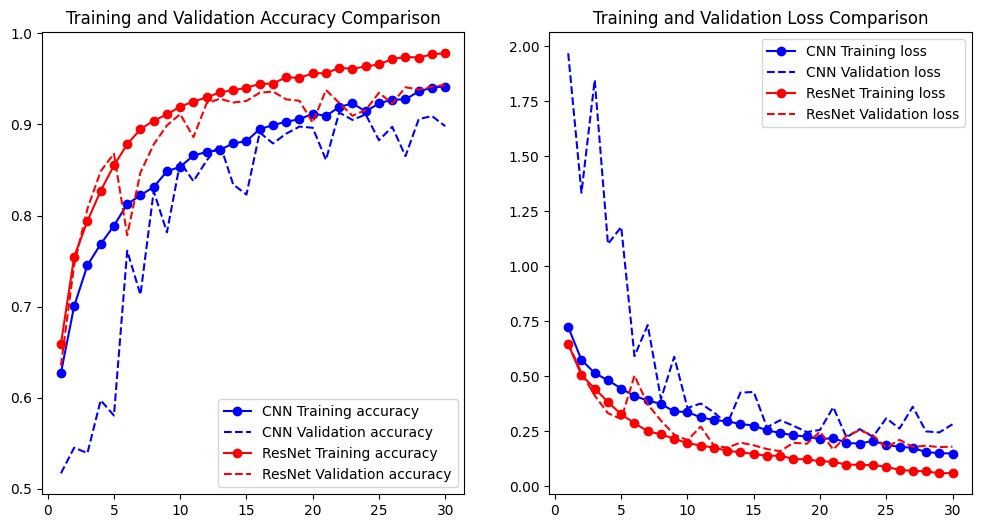

In [11]:
# Call this function after training both models
plot_comparison(hist_cnn, hist_resnet, max_epochs=30)

## Grad-CAM Analysis

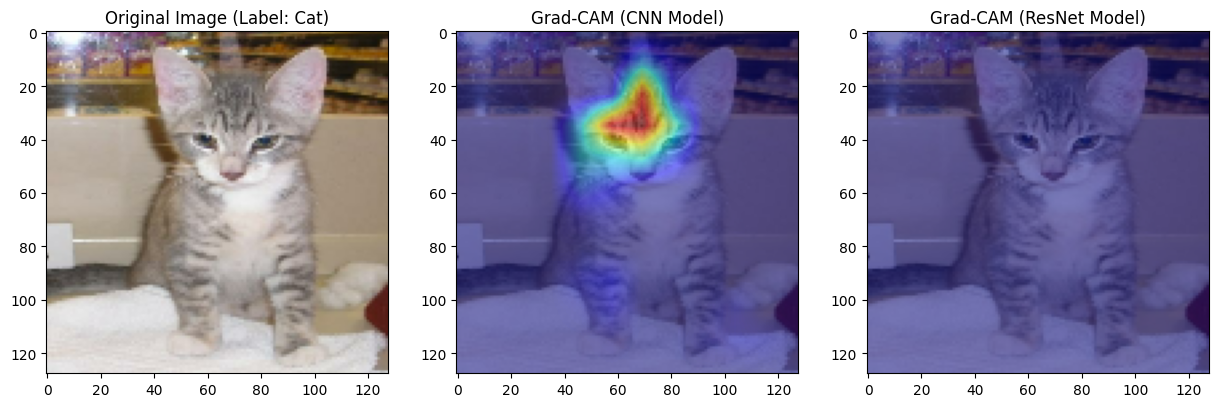

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
import random


# Grad-CAM Visualization function to compare two models
def plot_gradcam_comparison(baseline_model, attention_model, dataset, class_labels, original_dataset):
    # Select a random image from the validation dataset
    image_batch, label_batch = next(iter(dataset))
    random_index = random.randint(0, len(image_batch) - 1)  # Random index
    random_image = image_batch[random_index : random_index + 1]  # Select random image
    random_label = label_batch[random_index].numpy()  # Get the label

    # Fetch the corresponding original image (before preprocessing)
    original_image_batch, _ = next(iter(original_dataset))
    original_image = original_image_batch[random_index : random_index + 1]  # Original image

    # Create Grad-CAM objects for both models
    gradcam_baseline = Gradcam(baseline_model, clone=False)
    gradcam_attention = Gradcam(attention_model, clone=False)

    # For binary classification, we use BinaryScore targeting the true label
    score = BinaryScore(int(random_label))

    # Generate heatmaps for both models
    cam_baseline = gradcam_baseline(score, random_image, penultimate_layer=-1)
    cam_attention = gradcam_attention(score, random_image, penultimate_layer=-1)

    # Plot the original image and the Grad-CAM heatmaps side by side
    plt.figure(figsize=(15, 5))

    # Original Image (Unprocessed)
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[0].numpy().astype("uint8"))  # Ensure correct format
    plt.title(f"Original Image (Label: {class_labels[int(random_label)]})")

    # Grad-CAM for the Baseline Model
    plt.subplot(1, 3, 2)
    plt.imshow(original_image[0].numpy().astype("uint8"))  # Ensure correct format
    plt.imshow(cam_baseline[0], cmap="jet", alpha=0.5)  # Overlay the heatmap
    plt.title("Grad-CAM (CNN Model)")

    # Grad-CAM for the Self-Attention Model
    plt.subplot(1, 3, 3)
    plt.imshow(original_image[0].numpy().astype("uint8"))  # Ensure correct format
    plt.imshow(cam_attention[0], cmap="jet", alpha=0.5)  # Overlay the heatmap
    plt.title("Grad-CAM (ResNet Model)")

    plt.show()

# Example usage: Compare Grad-CAMs between baseline and self-attention models
class_labels = ["Cat", "Dog"]  # Adjust if needed
plot_gradcam_comparison(model_cnn, model_resnet, val_ds, class_labels, original_val_ds)

## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

2024-10-12 16:20:50.890316: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


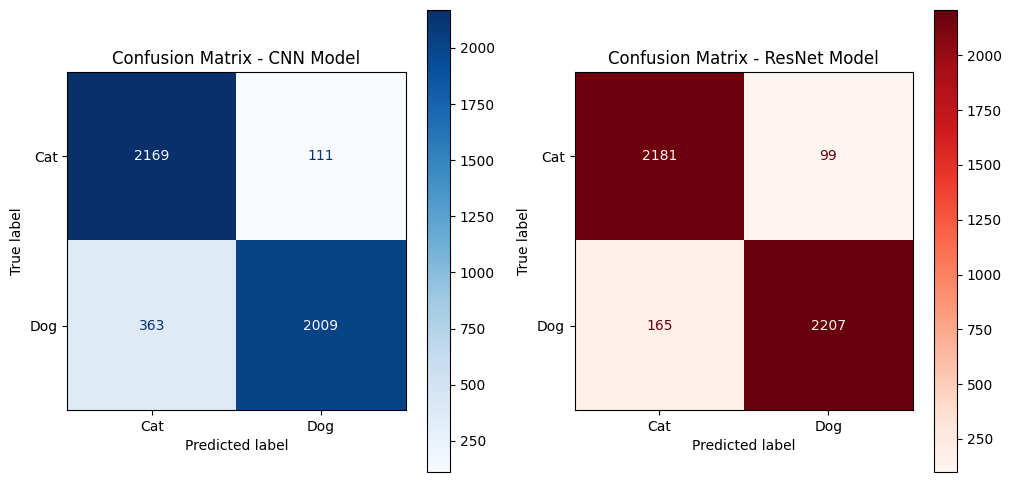

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to generate and plot confusion matrix for both models
def plot_confusion_matrix(baseline_model, resnet_model, dataset, class_labels):
    # Initialize lists to store true labels and predictions
    true_labels = []
    baseline_predictions = []
    resnet_predictions = []

    # Iterate through the dataset
    for images, labels in dataset:
        true_labels.extend(labels.numpy())  # Store the true labels

        # Get predictions for both models
        baseline_pred = baseline_model.predict(images, verbose=False)
        resnet_pred = resnet_model.predict(images)

        # Store the predicted classes (0 or 1) from the models
        baseline_predictions.extend(np.round(baseline_pred).astype(int))
        resnet_predictions.extend(np.round(resnet_pred).astype(int))

    # Compute confusion matrices for both models
    baseline_cm = confusion_matrix(true_labels, baseline_predictions)
    resnet_cm = confusion_matrix(true_labels, resnet_predictions)

    # Plot confusion matrix for baseline model
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(baseline_cm, display_labels=class_labels).plot(cmap='Blues', ax=plt.gca())
    plt.title('Confusion Matrix - CNN Model')

    # Plot confusion matrix for ResNet model
    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay(resnet_cm, display_labels=class_labels).plot(cmap='Reds', ax=plt.gca())
    plt.title('Confusion Matrix - ResNet Model')

    plt.show()

# Example usage to compare both models
class_labels = ["Cat", "Dog"]
plot_confusion_matrix(model_cnn, model_resnet, val_ds, class_labels)

## Performance Report

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Function to generate detailed performance metrics for both models
def model_performance_report(baseline_model, resnet_model, dataset):
    true_labels = []
    baseline_predictions = []
    resnet_predictions = []

    # Collect true labels and predictions for both models
    for images, labels in dataset:
        true_labels.extend(labels.numpy())
        baseline_pred = baseline_model.predict(images)
        resnet_pred = resnet_model.predict(images)
        baseline_predictions.extend(np.round(baseline_pred).astype(int))
        resnet_predictions.extend(np.round(resnet_pred).astype(int))

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    baseline_predictions = np.array(baseline_predictions)
    resnet_predictions = np.array(resnet_predictions)

    # Compute and display classification report (Precision, Recall, F1-Score)
    print("Classification Report - CNN Model:")
    print(classification_report(true_labels, baseline_predictions, target_names=["Cat", "Dog"]))

    print("\nClassification Report - ResNet Model:")
    print(classification_report(true_labels, resnet_predictions, target_names=["Cat", "Dog"]))

    # Compute AUC-ROC for both models
    auc_baseline = roc_auc_score(true_labels, baseline_predictions)
    auc_resnet = roc_auc_score(true_labels, resnet_predictions)

    print(f"\nAUC-ROC - CNN Model: {auc_baseline:.4f}")
    print(f"AUC-ROC - ResNet Model: {auc_resnet:.4f}")

# Example usage to compare performance
model_performance_report(model_cnn, model_resnet, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2024-10-12 16:21:14.227877: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
